In [20]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl

#Using newest versions of all libraries

In [21]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from resnet import ResNet18
from imcal import *
from imcal import CalorimeterDataset
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import plot_conf_matrix

In [22]:
#variables controlled by the user. Change these to fit your specific needs.

TRAIN_N_EVENTS = 10000 #Number of events to process for each class.
VAL_N_EVENTS = 3000 #Number of events to process for each class.
TEST_N_EVENTS = 15000 #Number of events to process for each class.
RES = 50 #resolution
CUT=True #Should cut be applied? Chooses different files if True.

#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_n2_M10", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12", "BH_n6_M10"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]

#Set data paths
if CUT:
    N_EVENTS = 10000
    TRAIN_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{N_EVENTS}_events.h5" for label in LABELS]
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_15000_events.h5" for label in TEST_LABELS]
    VAL_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_3000_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = 10000
    TRAIN_FILENAMES = [f"{label}_res{RES}_{N_EVENTS}_events.h5" for label in LABELS]
    TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
    VAL_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]

TRAIN_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TRAIN_FILENAMES[i]}" for i in range(CLASSES)]
VAL_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{VAL_FILENAMES[i]}" for i in range(CLASSES)]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

#Set a unique name for the model
labelstring = '_'.join([str(elem) for elem in PLOT_LABELS])
if CUT:
    MODEL_NAME = f"resnet_{str(int(time.time()))}_{labelstring}_CUT_res{RES}"
else: MODEL_NAME = f"resnet_{str(int(time.time()))}_{labelstring}"
print(MODEL_NAME)
#Where to save the model
SAVE_FOLDER = "../results/models"
SAVE_PATH = f"{SAVE_FOLDER}/{MODEL_NAME}.pt"

#Setup GPU if available
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

#Data processing
#filters=["saturate", "normalise"]
filters=None
transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        RandomRoll(roll_axis=0)
    )
#For plotting
ampl.use_atlas_style()   
#sn.set_theme(context="notebook", style="white", palette="Paired", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

resnet_1696846798_SPH_9_BH_n2_M10_BH_n4_M8_BH_n4_M10_BH_n4_M12_BH_n6_M10_CUT_res50
Running on the GPU


### Load data

In [23]:
#Load data

testpaths = [Path(path) for path in TEST_DATAPATHS]
trainpaths = [Path(path) for path in TRAIN_DATAPATHS]
valpaths = [Path(path) for path in VAL_DATAPATHS]

#Load lazily to save memory
test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=filters, transform=None, event_limit=TEST_N_EVENTS)
val_data = Hdf5Dataset(valpaths, TEST_LABELS, DEVICE, 
                        shuffle=True, filters=filters, transform=transforms, event_limit=VAL_N_EVENTS)
train_data = Hdf5Dataset(trainpaths, LABELS, DEVICE, 
                        shuffle=True, filters=filters, transform=transforms, event_limit=TRAIN_N_EVENTS)

#Load directly to speed up
#test_data = load_datasets(testpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms=None)
#train_data = load_datasets(trainpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms)


Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n2_M10_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M12_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n6_M10_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_3000_eve

Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_res50_STmin7_Nmin5_10000_events.h5.
Selecting 10000 events out of 10000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_res50_STmin7_Nmin5_10000_events.h5.
Selecting 10000 events out of 10000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M12_res50_STmin7_Nmin5_10000_events.h5.
Selecting 10000 events out of 10000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n6_M10_res50_STmin7_Nmin5_10000_events.h5.
Selecting 10000 events out of 10000.


### View the data

[['SPH_9', 'SPH_9'], ['BH_n2_M10', 'BH_n2_M10'], ['BH_n4_M8', 'BH_n4_M8'], ['BH_n4_M10', 'BH_n4_M10'], ['BH_n4_M12', 'BH_n4_M12'], ['BH_n6_M10', 'BH_n6_M10']]
[[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5]]
[[21, 56], [3096, 3027], [6074, 6094], [9092, 9099], [12037, 12011], [15094, 15018]]
Image shape:  (50, 50, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

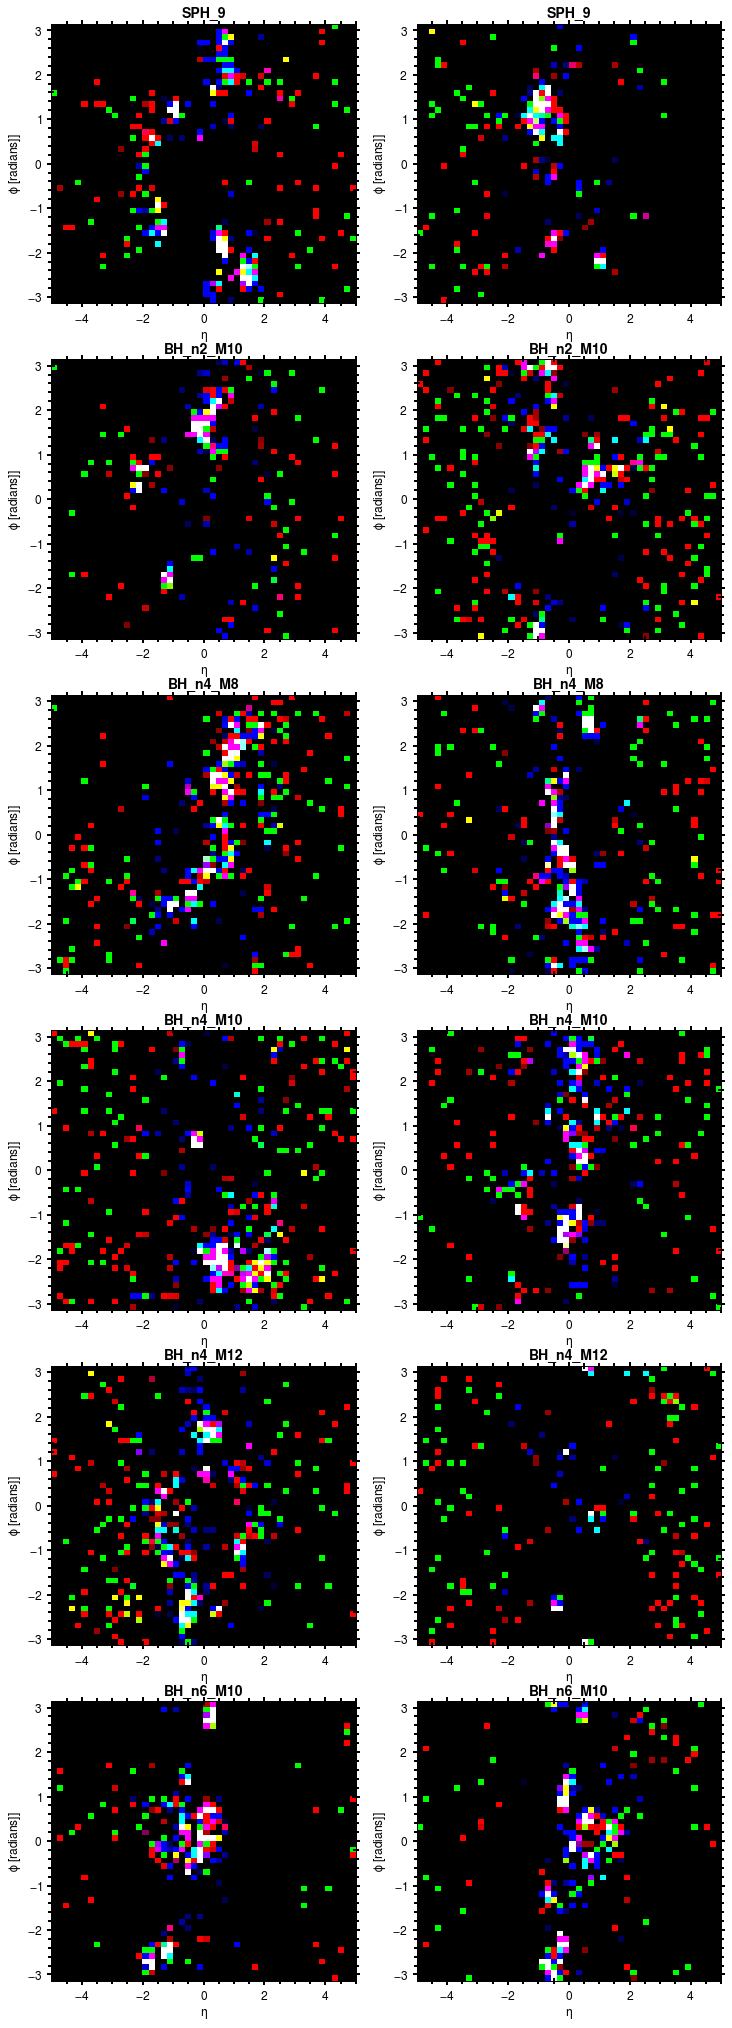

In [24]:
#Print some of the images
view_data(train_data, 2, CLASSES, PLOT_LABELS, RES, VAL_N_EVENTS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 441.1163   603.80695  644.92834  700.0092   836.45276 1153.8679
 1463.8107  1624.8425  1672.9225 ]
Looking at image 12984


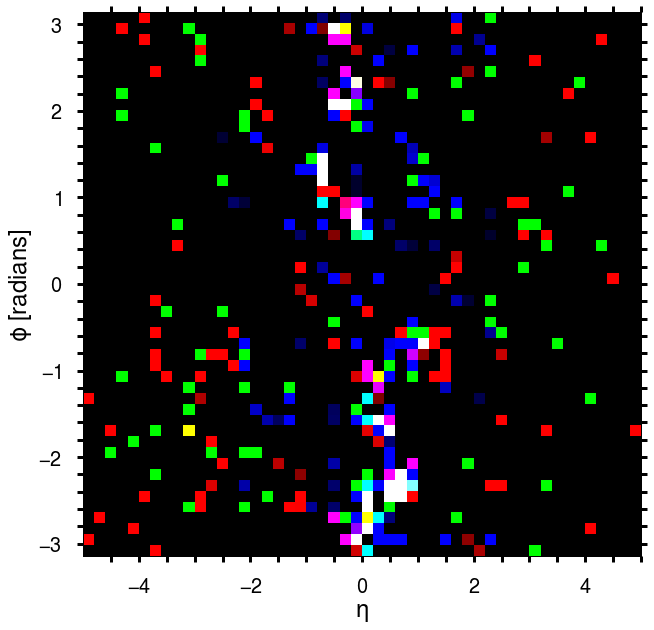

In [25]:
#Look at a random image more closely
k = np.random.randint(0, len(val_data))
image = val_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(image, extent=[-5, 5, -np.pi, np.pi], aspect='auto')
cal_image_plot_paper(ax)
ax.tick_params(which="both", direction="out", bottom=True, left=True, labelsize=20, pad=15, length=6, width=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


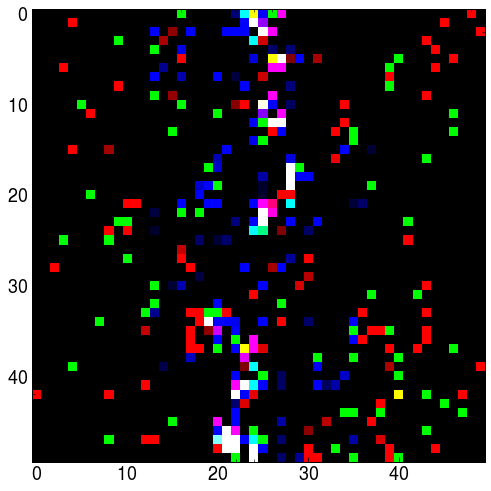

In [26]:
#Check augmentation on the same image
if transforms!=None:
    rolled_image = transforms(image)
    plt.imshow(rolled_image)

### Create net and train

In [27]:
#Create NN.
resnet = ResNet18(img_channels=3, num_classes=CLASSES)
resnet.to(DEVICE)
#Test that nothing major is wrong.
testimage, testlabel = val_data[0][0], val_data[0][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)))
print(testlabel)

torch.Size([1, 3, 50, 50])
tensor([[ 0.1775,  0.7568,  0.1553,  0.7649, -0.4314,  0.3553]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([0., 1., 0., 0., 0., 0.], device='cuda:0', dtype=torch.float64)


In [28]:
#Set optimizer, learning rate scheduler and train the model
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, 0.0001, 0.01, cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.001*10, step_size_up=5, mode="exp_range", gamma=0.85, cycle_momentum=False)
training_results = train(resnet, train_data, val_data, 2**8, 40, RES, DEVICE, optimizer, scheduler)

100%|██████████| 40/40 [1:09:06<00:00, 103.66s/it]


In [29]:
#Test that nothing major is wrong after training.
k = np.random.randint(0, len(val_data))
testimage, testlabel = val_data[k][0], val_data[k][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)), testlabel)

torch.Size([1, 3, 50, 50])
tensor([[ 2.2308, -0.6834, -1.9341, -0.7638, -1.4781, -0.9566]],
       device='cuda:0', grad_fn=<AddmmBackward0>) tensor([1., 0., 0., 0., 0., 0.], device='cuda:0', dtype=torch.float64)


### Inspect the results

(0.0, 1.8)

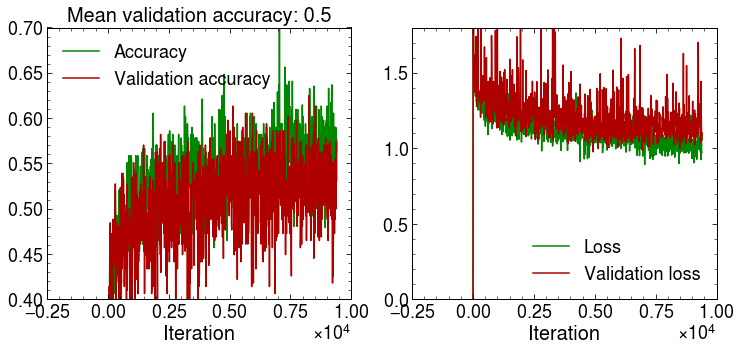

In [42]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
axs[0].set_ylim(0.4,0.7)
#axs[0].set_xlim(0)
axs[1].set_ylim(0, 1.8)

### Predict on test set and check accuracy

In [31]:
truth, preds, losses, values = predict(resnet, test_data, CLASSES, 1, RES, DEVICE, return_loss=True, return_values=True)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 90000/90000 [12:10<00:00, 123.23it/s]


In [32]:
#Save model
torch.save(resnet.state_dict(), SAVE_PATH)

[0.931 0.029 0.028 0.003 0.007 0.002 0.124 0.405 0.127 0.079 0.117 0.148
 0.165 0.107 0.576 0.046 0.033 0.073 0.075 0.302 0.148 0.105 0.128 0.243
 0.019 0.077 0.035 0.012 0.799 0.058 0.06  0.266 0.162 0.099 0.128 0.285]


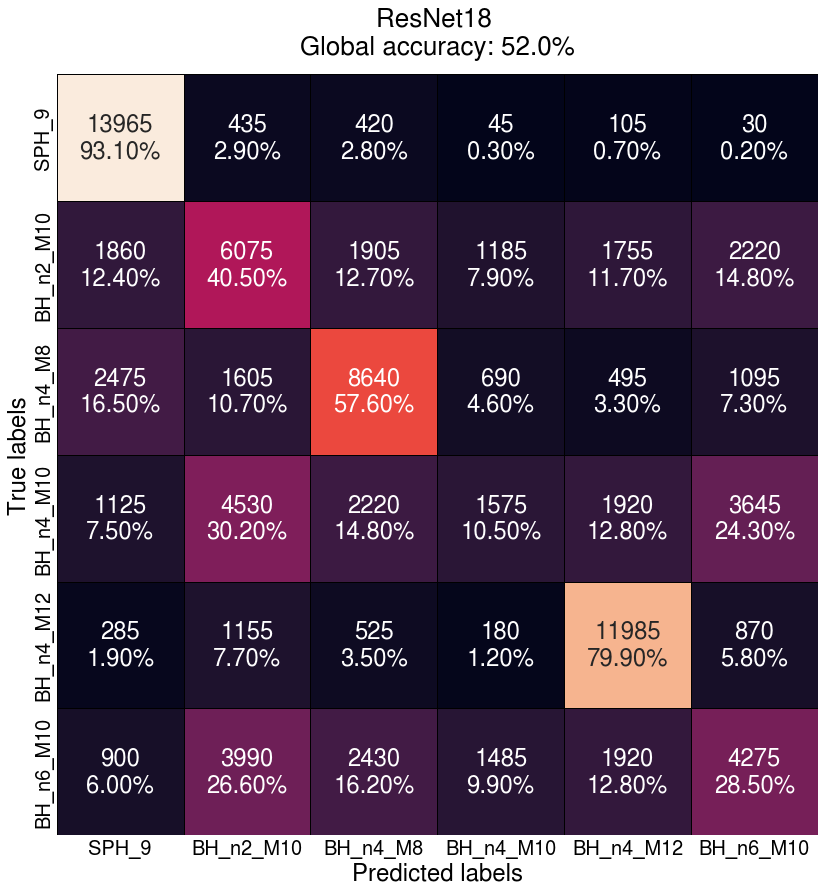

In [33]:
def plot_conf_matrix(confusion, accuracy, labels):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(14, 14))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
    cf_matrix = np.round(cf_matrix, 3)
    print(cf_matrix.flatten())
    group_counts = ["{0:0.0f}".format(value*TEST_N_EVENTS) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()]
    annot = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = False, 
            square=True, 
            fmt='', 
            cbar_kws={'format':'%.0f'},
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24)
    ax.set_ylabel('True labels', size=24)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=20)
    ax.yaxis.set_ticklabels(labels, size=20)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18 \nGlobal accuracy: {round(accuracy, 2)*100}%", size=26, pad=20)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
plot_conf_matrix(confusion, accuracy, PLOT_LABELS)

In [41]:
confusion["Event_ID"] = np.arange(0, len(confusion))
confusion["Correct_Pred"] = [confusion["Predictions"][i] == confusion["Truth"][i] for i in range(len(confusion))]
confusion["Losses"] = losses
confusion["Class_1_value"] = values[:,0]
confusion["Class_2_value"] = values[:,1]
confusion["Difference"] = abs(confusion["Class_1_value"] - confusion["Class_2_value"])
arg_chosen_value = np.asarray(preds.tolist())
chosen_value = [values[i, int(arg)].tolist() for i, arg in enumerate(arg_chosen_value)]
confusion["Best choice"] = chosen_value
wrong_id = confusion[confusion["Correct_Pred"]==False]["Event_ID"].tolist()

In [35]:
confusion

,Truth,Predictions,Event_ID,Correct_Pred,Losses,Class_1_value,Class_2_value,Difference,Best choice
0,0.0,0.0,0,True,0.638845,0.527902,0.167902,0.360000,0.527902
1,0.0,0.0,1,True,0.092973,0.911218,0.034248,0.876970,0.911218
2,0.0,0.0,2,True,0.010760,0.989297,0.005517,0.983781,0.989297
3,0.0,0.0,3,True,1.484974,0.226508,0.145313,0.081196,0.226508
4,0.0,0.0,4,True,0.164053,0.848697,0.070571,0.778126,0.848697
...,...,...,...,...,...,...,...,...,...
89995,5.0,0.0,89995,False,2.477202,0.453527,0.284858,0.168668,0.453527
89996,5.0,2.0,89996,False,1.640662,0.011179,0.217850,0.206671,0.329597
89997,5.0,2.0,89997,False,1.451945,0.000674,0.174390,0.173716,0.326650
89998,5.0,5.0,89998,True,1.129592,0.000167,0.271133,0.270966,0.323165


In [36]:
confusion.sort_values(by=["Losses"], ascending=False, inplace=True, ignore_index=True)
#confusion.sort_values(by=["Correct_Pred"], ascending=True, inplace=True, ignore_index=True)
#print(confusion[confusion["Truth"]>0])
print(confusion)

       Truth  Predictions  Event_ID  Correct_Pred        Losses  \
0        1.0          4.0     26653         False  1.710404e+01   
1        1.0          4.0     19962         False  1.147145e+01   
2        1.0          4.0     23607         False  1.056558e+01   
3        0.0          3.0       159         False  9.681310e+00   
4        1.0          4.0     27913         False  9.032174e+00   
...      ...          ...       ...           ...           ...   
89995    4.0          4.0     66410          True  8.344647e-07   
89996    4.0          4.0     74705          True  8.344647e-07   
89997    4.0          4.0     61455          True  2.384186e-07   
89998    4.0          4.0     63841          True  0.000000e+00   
89999    4.0          4.0     66382          True  0.000000e+00   

       Class_1_value  Class_2_value    Difference  Best choice  
0       3.657389e-43   3.730869e-08  3.730869e-08     0.999802  
1       1.664667e-21   1.042344e-05  1.042344e-05     0.992585  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for the hardest to classify image
[ 662.0676   796.47784  835.32764 1051.253   1378.6766  1384.5408
 1454.7281  1870.3358  1997.3004 ]
Looking at image 26653


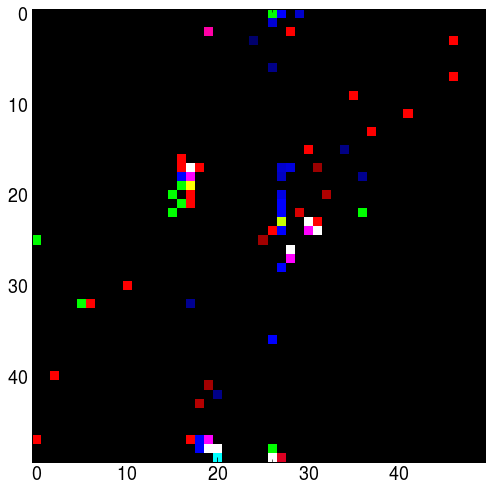

In [37]:
k = confusion["Event_ID"][0]
image = test_data[k][0].cpu()
print("Look at the highest histogram values values for the hardest to classify image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)

Text(0.5, 0, 'Softmax(y)')

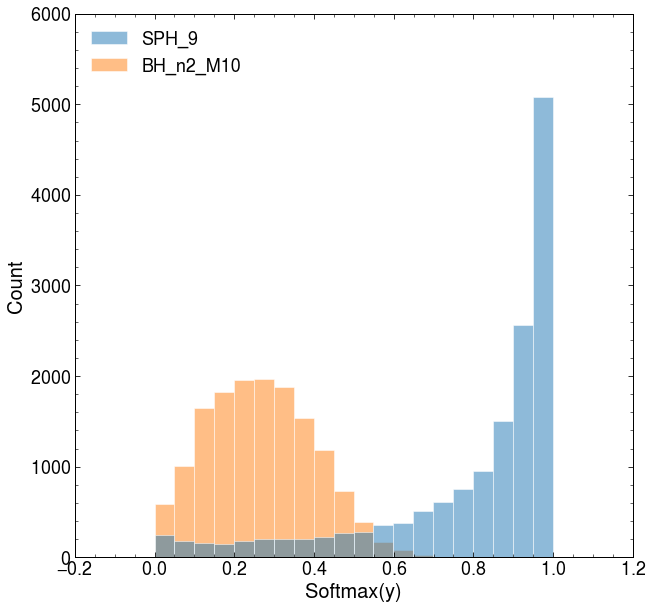

In [38]:
sph_softmax = confusion[confusion["Truth"]==0]["Class_1_value"]
bh_softmax = confusion[confusion["Truth"]==1]["Class_2_value"]
softmaxes = dict(zip(PLOT_LABELS, [sph_softmax, bh_softmax]))

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
sn.histplot(softmaxes, ax=ax, multiple="layer", stat="count", palette="tab10", bins=20)
sn.move_legend(ax, "upper left")
#ax.set_yscale("log")
ax.set_xlabel("Softmax(y)")